In [3]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed.csv')
df.head()

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.071562,0.370295,-0.264868,-0.678432,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,0.298465,-0.364226,-0.033312,-0.253081,-0.144348,-1.606014,0.137217,-0.243548,-0.16588,0.648997
1,-0.870615,0.370295,0.008674,-0.678432,-0.497470,0.651974,-2.322601,0.312313,-0.190100,-0.038110,...,-0.749164,-0.364226,-0.033312,-0.253081,-0.144348,-0.495788,-0.618051,-0.243548,-0.16588,0.284355
2,0.071562,0.370295,0.401148,1.091978,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,-0.027846,-0.364226,-0.033312,-0.253081,-0.144348,0.984513,0.137217,-0.243548,-0.16588,0.831662
3,0.071562,0.370295,1.117115,1.091978,-0.497470,2.401165,0.227107,0.312313,1.232693,1.452168,...,0.693472,-0.364226,-0.033312,-0.253081,-0.144348,2.094739,0.137217,-0.243548,-0.16588,1.126275
4,-0.870615,0.370295,0.123800,-0.678432,-0.301189,0.930463,0.227107,0.312313,-0.190100,1.452168,...,0.229768,-0.364226,-0.033312,-0.253081,-0.144348,0.614438,-0.618051,-0.243548,-0.16588,1.666301


In [5]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Feature Selection

### 2.1 Basic selection

In [6]:
corr_matr = df.corr().abs()
upper_tri = corr_matr.where(np.triu(np.ones(corr_matr.shape), k=1).astype(bool))

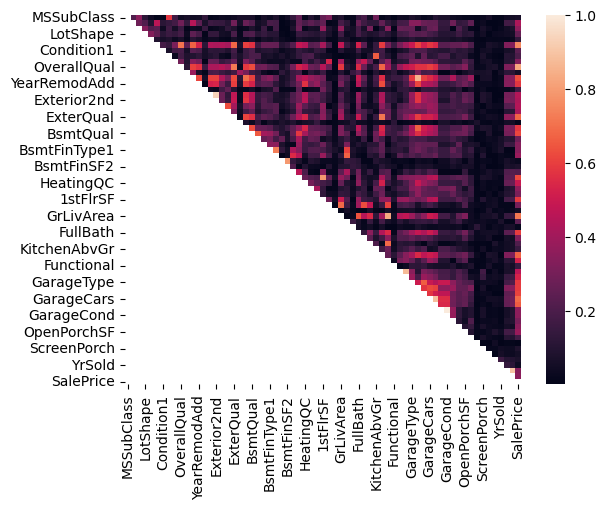

In [7]:
import seaborn as sns

plt.figure()
sns.heatmap(upper_tri)
plt.show()

In [8]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

df1 = df.drop(to_drop, axis=1)

['Exterior2nd', 'GarageCond']


### 2.2 Shap on XGBoost

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [10]:
import xgboost as xgb

base_model_xgb = xgb.XGBRegressor()

scores_xgb = cross_val_score(base_model_xgb, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-scores_xgb)

print(f'Mean RMSE: {rmse_xgb.mean()}')

Mean RMSE: 0.34797514504941496


In [11]:
import shap

base_model_xgb.fit(X, y)

explainer = shap.TreeExplainer(base_model_xgb)
shap_values_xgb = explainer.shap_values(X)

mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
importance_df_xgb = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_xgb
}).sort_values('importance', ascending=False)

importance_df_xgb.head(20)

/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,importance
9,OverallQual,0.332668
36,GrLivArea,0.203534
5,Neighborhood,0.137897
25,BsmtFinSF1,0.053103
29,TotalBsmtSF,0.046483
43,KitchenQual,0.044443
33,1stFlrSF,0.043392
10,OverallCond,0.041443
52,GarageArea,0.040548
24,BsmtFinType1,0.039515


In [12]:
most_rel_feat_xgb = importance_df_xgb['feature'].values[:20].tolist()
print(most_rel_feat_xgb)

['OverallQual', 'GrLivArea', 'Neighborhood', 'BsmtFinSF1', 'TotalBsmtSF', 'KitchenQual', '1stFlrSF', 'OverallCond', 'GarageArea', 'BsmtFinType1', 'LotArea', 'ExterQual', 'GarageCars', 'YearRemodAdd', 'YearBuilt', '2ndFlrSF', 'BsmtFullBath', 'SaleCondition', 'GarageType', 'GarageYrBlt']


Mean RMSE: 0.3436587633928066


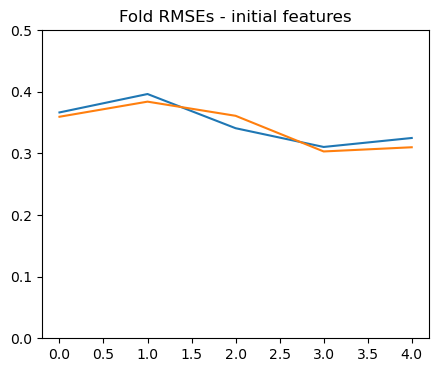

In [13]:
import xgboost as xgb

model = xgb.XGBRegressor()

scores_xgb_2 = cross_val_score(model, X[most_rel_feat_xgb], y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb_2 = np.sqrt(-scores_xgb_2)

print(f'Mean RMSE: {rmse_xgb_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_2)
plt.show()

### 2.3 Shap on SVR

In [14]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm = cross_val_score(base_model_svr, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm = np.sqrt(-scores_svm)

print(f'Mean RMSE: {rmse_svm.mean()}')

Mean RMSE: 0.34676272840430944


In [15]:
import shap

base_model_svr.fit(X,y)
X_summary = shap.kmeans(X_train, 10)

explainer = shap.KernelExplainer(base_model_svr.predict, X_summary)

shap_values_svm = explainer.shap_values(X_test[:100])

mean_shap_svm = np.abs(shap_values_svm).mean(axis=0)
importance_df_svm = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_svm
}).sort_values('importance', ascending=False)

importance_df_svm.head(20)

100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


,feature,importance
36,GrLivArea,0.122234
9,OverallQual,0.102748
34,2ndFlrSF,0.070268
33,1stFlrSF,0.069167
29,TotalBsmtSF,0.063949
5,Neighborhood,0.050265
10,OverallCond,0.045643
11,YearBuilt,0.038978
51,GarageCars,0.035694
1,MSZoning,0.033512


In [16]:
most_rel_feat_svm = importance_df_svm['feature'].values[:20].tolist()
print(most_rel_feat_svm)

['GrLivArea', 'OverallQual', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'Neighborhood', 'OverallCond', 'YearBuilt', 'GarageCars', 'MSZoning', 'BsmtFinSF1', 'LotArea', 'CentralAir', 'BsmtFinType1', 'TotRmsAbvGrd', 'GarageArea', 'FullBath', 'SaleCondition', 'GarageCond', 'Condition1']


Mean RMSE: 0.34088084499806526


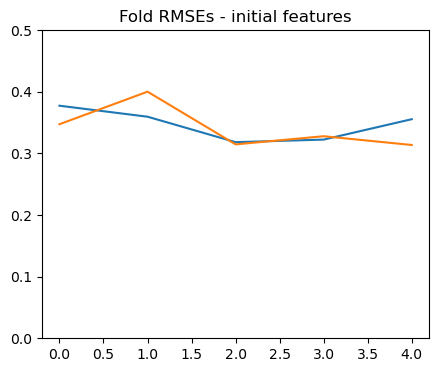

In [17]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm_2 = cross_val_score(base_model_svr, X[most_rel_feat_svm], y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm_2 = np.sqrt(-scores_svm_2)

print(f'Mean RMSE: {rmse_svm_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_svm)
plt.plot(rmse_svm_2)
plt.show()

### 2.4 Cumulative importance

In [18]:
importance_df = pd.DataFrame({
    'feature': importance_df_svm['feature'],
    'importance_svm': importance_df_svm['importance'],
    'importance_xgb': importance_df_xgb['importance']
})

importance_df['rank_svm'] = importance_df['importance_svm'].rank(ascending=False, method='min')
importance_df['rank_xgb'] = importance_df['importance_xgb'].rank(ascending=False, method='min')

importance_df['rank_sum'] = importance_df['rank_svm'] + importance_df['rank_xgb']
importance_df = importance_df.sort_values('rank_sum', ascending=True)

importance_df.head(20)

,feature,importance_svm,importance_xgb,rank_svm,rank_xgb,rank_sum
36,GrLivArea,0.122234,0.203534,1.0,2.0,3.0
9,OverallQual,0.102748,0.332668,2.0,1.0,3.0
5,Neighborhood,0.050265,0.137897,6.0,3.0,9.0
29,TotalBsmtSF,0.063949,0.046483,5.0,5.0,10.0
33,1stFlrSF,0.069167,0.043392,4.0,7.0,11.0
25,BsmtFinSF1,0.033156,0.053103,11.0,4.0,15.0
10,OverallCond,0.045643,0.041443,7.0,8.0,15.0
34,2ndFlrSF,0.070268,0.019303,3.0,16.0,19.0
51,GarageCars,0.035694,0.026223,9.0,13.0,22.0
2,LotArea,0.023875,0.036855,12.0,11.0,23.0


In [27]:
most_rel_feat = importance_df['feature'].values[:20].tolist()
print(most_rel_feat)

['GrLivArea', 'OverallQual', 'Neighborhood', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'OverallCond', '2ndFlrSF', 'GarageCars', 'LotArea', 'YearBuilt', 'BsmtFinType1', 'GarageArea', 'KitchenQual', 'YearRemodAdd', 'SaleCondition', 'MSZoning', 'CentralAir', 'TotRmsAbvGrd', 'Condition1']


In [20]:
most_rel_feat = ['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'OverallCond', 'KitchenQual', '2ndFlrSF', 'GarageArea', 'LotArea', 'YearBuilt', 'BsmtFinType1', 'YearRemodAdd']

Mean RMSE XGB: 0.34324227003196184
Mean RMSE SVM: 0.3341086959150952


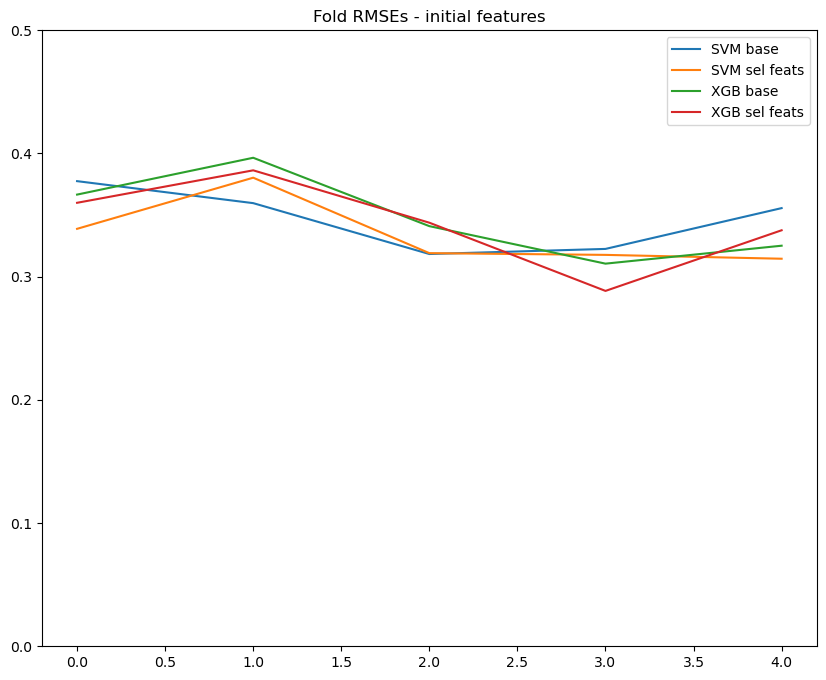

In [28]:
from sklearn.svm import SVR
import xgboost as xgb

base_model_svr = SVR()

scores_xgb_3 = cross_val_score(base_model_xgb, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')
scores_svm_3 = cross_val_score(base_model_svr, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')

rmse_xgb_3 = np.sqrt(-scores_xgb_3)
rmse_svm_3 = np.sqrt(-scores_svm_3)

print(f'Mean RMSE XGB: {rmse_xgb_3.mean()}')
print(f'Mean RMSE SVM: {rmse_svm_3.mean()}')

plt.figure(figsize=(10,8))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)

plt.plot(rmse_svm)
plt.plot(rmse_svm_3)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_3)

plt.legend([
    "SVM base",
    "SVM sel feats",
    "XGB base",
    "XGB sel feats"
])

plt.show()

In [29]:
X_sel = X[most_rel_feat]

## 3. Model Optimization

In [30]:
import optuna
from sklearn.model_selection import cross_val_score

from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

def optimization_plots(study):
    # fig1 = plot_optimization_history(study)
    # fig1.show()

    # fig2 = plot_contour(study)
    # fig2.show()

    fig3 = plot_rank(study)
    fig3.show()

    # fig4 = plot_param_importances(study)
    # fig4.show()

In [31]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

### 3.1 XGBoost

In [35]:
import math
import xgboost as xgb

study_name = 'kag1-2-XGB-3'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_xgb(trial):
    num_estimators = trial.suggest_int("num_estimators", 100, 2000, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 16, log=True)
    
    model = xgb.XGBRegressor(n_estimators=num_estimators, max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1, tree_method="hist", enable_categorical=True)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", )
    
    return math.sqrt(-scores.mean())

study_xgb = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize')

[I 2025-08-26 23:08:51,408] A new study created in RDB with name: kag1-2-XGB-3


In [36]:
study_xgb.optimize(optimize_xgb, n_trials=75)
print(study_xgb.best_trial)

[I 2025-08-26 23:09:03,118] Trial 0 finished with value: 0.3213527807127772 and parameters: {'num_estimators': 1137, 'learning_rate': 0.07646298682707449, 'max_depth': 5}. Best is trial 0 with value: 0.3213527807127772.
[I 2025-08-26 23:09:14,180] Trial 1 finished with value: 0.36553434109596905 and parameters: {'num_estimators': 824, 'learning_rate': 0.04065518725600234, 'max_depth': 14}. Best is trial 0 with value: 0.3213527807127772.
[I 2025-08-26 23:09:17,623] Trial 2 finished with value: 0.3452990718642933 and parameters: {'num_estimators': 205, 'learning_rate': 0.07087651658722952, 'max_depth': 8}. Best is trial 0 with value: 0.3213527807127772.
[I 2025-08-26 23:09:19,034] Trial 3 finished with value: 0.4381083435807928 and parameters: {'num_estimators': 355, 'learning_rate': 0.006601485665153183, 'max_depth': 2}. Best is trial 0 with value: 0.3213527807127772.
[I 2025-08-26 23:09:26,293] Trial 4 finished with value: 0.32508787968210406 and parameters: {'num_estimators': 818, 'le

FrozenTrial(number=32, state=1, values=[0.3027691471677248], datetime_start=datetime.datetime(2025, 8, 26, 23, 11, 40, 653169), datetime_complete=datetime.datetime(2025, 8, 26, 23, 11, 46, 489651), params={'num_estimators': 1535, 'learning_rate': 0.040556678833671346, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_estimators': IntDistribution(high=2000, log=True, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.005, step=None), 'max_depth': IntDistribution(high=16, log=True, low=2, step=1)}, trial_id=33, value=None)


In [37]:
optimization_plots(study_xgb)

### 3.2 SVR

In [38]:
import math
from sklearn.svm import SVR

study_name = 'kag1-2-SVR-3'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_svr(trial):
    c = trial.suggest_float("c", 0.1, 100, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 1, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 1, log=True)
    
    model = SVR(C=c, gamma=gamma, epsilon=epsilon)
    scores = cross_val_score(model, X_sel, y, cv=kf, scoring="neg_mean_squared_error")
    
    return math.sqrt(-scores.mean())

study_svr = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-26 23:17:24,368] A new study created in RDB with name: kag1-2-SVR-3


In [39]:
study_svr.optimize(optimize_svr, n_trials=100)
print(study_svr.best_trial.params)

[I 2025-08-26 23:17:24,679] Trial 0 finished with value: 0.29898965424390356 and parameters: {'c': 3.1886215729781218, 'gamma': 0.003986058960631315, 'epsilon': 0.010601694764024812}. Best is trial 0 with value: 0.29898965424390356.
[I 2025-08-26 23:17:24,782] Trial 1 finished with value: 0.36937028945148676 and parameters: {'c': 81.39629048484049, 'gamma': 0.01578151927921954, 'epsilon': 0.5300344778396896}. Best is trial 0 with value: 0.29898965424390356.
[I 2025-08-26 23:17:25,762] Trial 2 finished with value: 0.3232412811827782 and parameters: {'c': 94.66522593378616, 'gamma': 0.009631306220855403, 'epsilon': 0.10906345092148458}. Best is trial 0 with value: 0.29898965424390356.
[I 2025-08-26 23:17:26,210] Trial 3 finished with value: 0.4991823001098152 and parameters: {'c': 3.2423310869637554, 'gamma': 0.18590398370169717, 'epsilon': 0.0016657467726557708}. Best is trial 0 with value: 0.29898965424390356.
[I 2025-08-26 23:17:26,476] Trial 4 finished with value: 0.31343691577300686

{'c': 52.66835649180049, 'gamma': 0.0010611743654896802, 'epsilon': 0.0762695603570286}


In [40]:
optimization_plots(study_svr)

### 3.3 Neural Networks

In [41]:
import math
from sklearn.neural_network import MLPRegressor

study_name = 'kag1-2-MLP-1-x_all'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_mlp(trial):
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    alpha = trial.suggest_float("alpha", 0.001, 10, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    layers = []
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f"n_neurons_{i}", 4, 128, log=True)
        layers.append(n_neurons)
        
    model = MLPRegressor(hidden_layer_sizes=layers, alpha=alpha, learning_rate_init=lr, max_iter=1000)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    
    return math.sqrt(-scores.mean())

study_mlp = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction='minimize')    

[I 2025-08-26 23:18:00,167] A new study created in RDB with name: kag1-2-MLP-1-x_all


In [42]:
study_mlp.optimize(optimize_mlp, n_trials=100)
print(study_mlp.best_value, study_mlp.best_params)

[I 2025-08-26 23:18:00,675] Trial 0 finished with value: 0.31660809052469524 and parameters: {'lr': 0.00886600337951808, 'alpha': 0.08115464968720451, 'num_layers': 2, 'n_neurons_0': 5, 'n_neurons_1': 7}. Best is trial 0 with value: 0.31660809052469524.
[I 2025-08-26 23:18:01,315] Trial 1 finished with value: 0.294007682413187 and parameters: {'lr': 0.003383180380785183, 'alpha': 2.08081350423448, 'num_layers': 1, 'n_neurons_0': 14}. Best is trial 1 with value: 0.294007682413187.
[I 2025-08-26 23:18:01,984] Trial 2 finished with value: 0.34164898315225856 and parameters: {'lr': 0.05274288797534473, 'alpha': 0.01208461599946563, 'num_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 19}. Best is trial 1 with value: 0.294007682413187.
[I 2025-08-26 23:18:03,777] Trial 3 finished with value: 0.3884492863951394 and parameters: {'lr': 0.00025880842929535043, 'alpha': 0.01799103284453451, 'num_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 22}. Best is trial 1 with value: 0.294007682413187.
[I 20

0.28725807200692305 {'lr': 0.0011593870736073646, 'alpha': 2.366153106431099, 'num_layers': 1, 'n_neurons_0': 106}


In [43]:
optimization_plots(study_mlp)

### 3.4 Nearest Neighbor

In [44]:
import math
from sklearn.neighbors import KNeighborsRegressor

study_name = 'kag1-2-KNN-1'
storage_name = 'sqlite:///{}.db'.format(study_name)

def optimize_knn(trial):
    k = trial.suggest_int('k', 1, 1000, log=True)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    attributes = trial.suggest_categorical('attribtues', ['most_rel', 'all'])
    
    model = KNeighborsRegressor(k, weights=weights)
    
    if attributes == 'most_rel':
        scores = cross_val_score(model, X[most_rel_feat], y, cv=5, scoring='neg_mean_squared_error')
    else:
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        
    return math.sqrt(-scores.mean())

study_knn = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-26 23:21:46,327] A new study created in RDB with name: kag1-2-KNN-1


In [45]:
study_knn.optimize(optimize_knn, n_trials=900)
print(study_knn.best_value, study_knn.best_params)

[I 2025-08-26 23:21:46,393] Trial 0 finished with value: 0.36779637608669774 and parameters: {'k': 18, 'weights': 'distance', 'attribtues': 'most_rel'}. Best is trial 0 with value: 0.36779637608669774.
[I 2025-08-26 23:21:46,425] Trial 1 finished with value: 0.5163058225431931 and parameters: {'k': 1, 'weights': 'distance', 'attribtues': 'all'}. Best is trial 0 with value: 0.36779637608669774.
[I 2025-08-26 23:21:46,459] Trial 2 finished with value: 0.4068656801160716 and parameters: {'k': 13, 'weights': 'distance', 'attribtues': 'all'}. Best is trial 0 with value: 0.36779637608669774.
[I 2025-08-26 23:21:46,488] Trial 3 finished with value: 0.4114242837019273 and parameters: {'k': 6, 'weights': 'uniform', 'attribtues': 'all'}. Best is trial 0 with value: 0.36779637608669774.
[I 2025-08-26 23:21:46,518] Trial 4 finished with value: 0.3620280368603557 and parameters: {'k': 14, 'weights': 'distance', 'attribtues': 'most_rel'}. Best is trial 4 with value: 0.3620280368603557.
[I 2025-08-26

0.3620280368603557 {'k': 14, 'weights': 'distance', 'attribtues': 'most_rel'}


## 4. Predictions

In [46]:
X_test = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed_test.csv')

for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = X_test[col].astype("category")

X_test_sel = X_test[most_rel_feat]
    
print(X_test.shape)
X_test.head()

(1459, 66)


,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.870615,-1.745865,0.489633,-0.678432,-0.301189,-0.599170,-2.322601,0.312313,-0.190100,-0.783249,...,0.415830,-0.749164,-0.364226,-0.033312,2.725899,-0.144348,-0.125713,1.647753,-0.243548,-0.16588
1,-0.870615,0.370295,1.118780,1.091978,-0.017453,-0.599170,0.227107,0.312313,-0.190100,-0.038110,...,2.571841,-0.130891,-0.364226,-0.033312,-0.253081,90.963525,-0.125713,1.647753,-0.243548,-0.16588
2,0.071562,0.370295,1.014834,1.091978,-0.301189,0.302025,0.227107,0.312313,1.232693,-0.783249,...,1.029398,-0.165240,-0.364226,-0.033312,-0.253081,-0.144348,-1.235938,1.647753,-0.243548,-0.16588
3,0.071562,0.370295,0.098587,1.091978,-0.301189,0.302025,0.227107,0.312313,1.232693,-0.038110,...,2.290622,-0.130891,-0.364226,-0.033312,-0.253081,-0.144348,-0.125713,1.647753,-0.243548,-0.16588
4,1.484829,0.370295,-1.084305,1.091978,-0.301189,1.994270,0.227107,0.289881,-0.190100,1.452168,...,-0.777219,0.659124,-0.364226,-0.033312,3.321695,-0.144348,-1.976089,1.647753,-0.243548,-0.16588


### 4.1 Simple models

In [47]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1535, max_depth=2, learning_rate=0.04055, n_jobs=-1)
xgb_model.fit(X, y)

raw_predictions_xgb = xgb_model.predict(X_test)

In [49]:
from sklearn import svm

svm_model = svm.SVR(C=52.6683, gamma=0.001061, epsilon=0.07627)
svm_model.fit(X[most_rel_feat], y)

raw_predictions_svr = svm_model.predict(X_test_sel)

In [50]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=[106], alpha=2.3661531, learning_rate_init=0.00115938, max_iter=2000)
mlp_model.fit(X[most_rel_feat], y)

raw_predictions_mlp = mlp_model.predict(X_test_sel)

In [64]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(14, weights='distance')
knn_model.fit(X[most_rel_feat], y)

raw_predictions = knn_model.predict(X_test_sel)

### 4.2 Stacking

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso

feat_sel_all = ColumnTransformer(
    [("sel_all", "passthrough", X.columns)], remainder="drop"
)
feat_sel_most_rel = ColumnTransformer(
    [("sel_most_rel", "passthrough", most_rel_feat)], remainder="drop"
)

xgb_pipe = Pipeline(
    [
        ("select", feat_sel_all),
        (
            "xgb",
            xgb.XGBRegressor(
                n_estimators=1535, max_depth=2, learning_rate=0.04055, n_jobs=-1
            ),
        ),
    ]
)

svr_pipe = Pipeline(
    [
        ("select", feat_sel_most_rel),
        ("svr", svm.SVR(C=52.6683, gamma=0.001061, epsilon=0.07627)),
    ]
)

mlp_pipe = Pipeline(
    [
        ("select", feat_sel_all),
        (
            "mlp",
            MLPRegressor(
                hidden_layer_sizes=[106],
                alpha=2.3661531,
                learning_rate_init=0.00115938,
                max_iter=2000,
            ),
        ),
    ]
)

knn_pipe = Pipeline(
    [
        ('select', feat_sel_most_rel),
        ('knn', KNeighborsRegressor(n_neighbors=14, weights='distance'))
    ]
)


def createStack(final_model):
    return StackingRegressor(
        [("svr", svr_pipe), ("xgb", xgb_pipe), ("mlp", mlp_pipe), ('knn', knn_pipe)],
        final_estimator=final_model,
        passthrough=False,
        cv=5,
    )


stack = createStack(SVR(C=96.9590, gamma=0.11754, epsilon=0.01695))
stack

,estimators,"[('svr', ...), ('xgb', ...), ...]"
,final_estimator,SVR(C=99.8946...gamma=0.05349)
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,transformers,"[('sel_most_rel', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [78]:
stack.fit(X, y)

raw_predictions = stack.predict(X_test)

#### 4.3.1 Stacking optimization

In [66]:
from sklearn.model_selection import KFold

kf2 = KFold(n_splits=5, shuffle=True, random_state=28)

In [67]:
from sklearn.model_selection import cross_val_predict

oof_preds = []
oof_preds.append(cross_val_predict(xgb_model, X, y, cv=kf2, method='predict').reshape(-1, 1))
oof_preds.append(cross_val_predict(svm_model, X[most_rel_feat], y, cv=kf2, method='predict').reshape(-1, 1))
oof_preds.append(cross_val_predict(mlp_model, X, y, cv=kf2, method='predict').reshape(-1, 1))
oof_preds.append(cross_val_predict(knn_model, X[most_rel_feat], y, cv=kf2, method='predict').reshape(-1, 1))

meta_X = np.hstack(oof_preds)
meta_y = y

In [74]:
import math
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

study_name = 'kag1-2-STK-3-all'
storage_name = 'sqlite:///{}.db'.format(study_name)

def optimize_stk_2(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "lasso", "elasticnet", "svr"])
    
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha_r", 1e-3, 1e3, log=True)
        final_model = Ridge(alpha=alpha)
    
    elif model_type == "lasso":
        alpha = trial.suggest_float("alpha_l", 1e-3, 1e3, log=True)
        final_model = Lasso(alpha=alpha)
    
    elif model_type == "elasticnet":
        alpha = trial.suggest_float("alpha_e", 1e-3, 1e3, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        final_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)
    
    else:  # svr
        C = trial.suggest_float("C", 1e-2, 1e2, log=True)
        gamma = trial.suggest_float("gamma", 1e-3, 1, log=True)
        epsilon = trial.suggest_float("epsilon", 1e-3, 1, log=True)
        final_model = SVR(C=C, gamma=gamma, epsilon=epsilon)
    
    scores = cross_val_score(final_model, meta_X, meta_y, cv=kf2, scoring="neg_mean_squared_error")
    return math.sqrt(-np.mean(scores))

study_stk2 = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-27 00:24:49,736] Using an existing study with name 'kag1-2-STK-3-all' instead of creating a new one.


In [75]:
# study_stk2.optimize(optimize_stk_2, n_trials=1000)
print(study_stk2.best_value, study_stk2.best_params)

0.2774377808591569 {'model': 'svr', 'C': 96.95903552382411, 'gamma': 0.1175436638330313, 'epsilon': 0.016959441101204002}


In [ ]:
optimization_plots(study_stk2)

## 5 Submission

In [79]:
import json

with open('house-prices-advanced-regression-techniques/normalization_values.json', 'r') as f:
    norm_values = json.load(f)

predictions = np.exp(raw_predictions * norm_values['std']['SalePrice'] + norm_values['mean']['SalePrice'])

In [80]:
submission = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': predictions,
})

submission.to_csv('house-prices-advanced-regression-techniques/submission.csv', index=False)